In [1]:
import os 
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]


In [2]:
simsnames

['6.96e11', '8.26e11', '7.08e11', '1.12e12', '2.79e12', '7.55e11']

In [3]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob

In [4]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [5]:
def calcRbir_cv(data, fold=5):
    fold = int(fold)

    args = data['feh'], data['age']
    args_name = '[Fe/H]', 'τ'
    
    X = list(args)
    X_names = list(args_name)
    
    for a, b in combinations_with_replacement(args, 2):
        X.append(a * b)

    
    for a, b in combinations_with_replacement(args_name, 2):
        X_names.append(str(a + '*' + b))
        
    X = np.array(X).T


    # Define the number of training and validating stars.
    Ntest = int(1./float(fold)*np.shape(X)[0])
    y = data['Rbir'].values
    ypred = np.zeros(len(y))
    
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
        
    weights = np.zeros((len(X_names)+1, fold))
        
    for i in range(fold):
        if i == fold-1:
            startind = int(-Ntest)
            endind = int(len(shuffle_inds)-1)
        else:
            startind = int(i*Ntest)
            endind = int(Ntest*(i+1))
            
        train_inds = np.append(shuffle_inds[:startind],shuffle_inds[endind:])
        test_inds = shuffle_inds[startind:endind]
        y_train, X_train = y[train_inds], X[train_inds, :]
        y_test, X_test = y[test_inds], X[test_inds, :]

        weights[:, i] = train(y_train, X_train)

        A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
        y_predict = np.dot(weights[:, i].T, A.T)
        ypred[test_inds] = y_predict

    return np.append(['$θ_C$'],X_names), [np.mean(weights[i,:]) for i in range(len(X_names)+1)], [np.std(weights[i,:]) for i in range(len(X_names)+1)], y, ypred

def calcRstd(data, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        data_loc = data.loc[(data['Rbir']>Rbirbin[i])&(data['Rbir']<Rbirbin[i+1])].reset_index(drop=True)
        Rstds[i] = np.std(data_loc['R']-data_loc['Rbir'])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def calcRstd_inf(infRbir, trueRbir, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        m = (trueRbir>Rbirbin[i])&(trueRbir<Rbirbin[i+1])
        Rstds[i] = np.std(trueRbir[m]-infRbir[m])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [18]:
cols = ['iord','r','z','x','y']
def calc_bar_angle(data, rbar=3.5, drbar=0.5):
    rbar=3
    drbar=0.1
    dub=3
    
    data['R'], data['phi'] = cart2pol(data['x'], data['y'])
    data_r = data.loc[abs(data['R']-rbar)<drbar].reset_index(drop=True)
    dens = np.histogram(data_r['phi'],bins=np.linspace(-np.pi,np.pi,360));

    ### FFT
    degs = (dens[1][:-1]+dens[1][1:])/2
    dens_p = dens[0]

    """
    for i in range(dub):
        degs = np.append(degs, (degs+(i+1)*np.pi))
        dens_p = np.append(dens_p, dens_p)
    """
    #plt.plot(dens[1][:-1], dens[0], 'k-')
    #plt.plot(dens[1][:-1], np.sin(2*dens[1][:-1]-2)*100)

    N = len(dens_p)
    Ts = (max(degs)-min(degs))/N
    yf = np.fft.fft(dens_p-np.mean(dens_p))

    Y = 2./N*abs(yf[0:N//2])

    barangle=-np.angle(yf[2])/2.

    return barangle, 2./N*abs(yf[2])

def generatepkl(simname):
    print(simname)
    allsnaps = glob.glob(simname+'/*.?????')
    
    agepickle = readsimdata(simname.split('_')[0][1:],True, 15, 5)
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    allages_rs = np.zeros(len(sortage))
        
    for j in trange(len(allages_rs)):
        if os.path.exists(snaplookup[sortage[j]]+'.pkl'):
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
            try:
                this_snap['x']
            except:
                s = pb.load(snaplookup[sortage[j]])
                h=s.halos()
                try:
                    pb.analysis.angmom.faceon(h[1])
                except:
                    print('no halo!')
                    continue
                s.physical_units()
                sim = h[1]

                stars = sim.s
                if len(stars)==0:
                    print('no stars!')
                    continue

                try:
                    stars['iord']
                except:
                    print('no IDs!')
                    continue
                this_snap = pd.DataFrame({k:stars[k] for k in cols})

                this_snap = pd.merge(this_snap, agepickle[['iord', 'age', 'feh', 'Rbir','zbir']], left_on='iord', right_on='iord', how='inner')
                this_snap.to_pickle(snaplookup[sortage[j]]+'.pkl')
        else:
            s = pb.load(snaplookup[sortage[j]])
            h=s.halos()
            try:
                pb.analysis.angmom.faceon(h[1])
            except:
                print('no halo!')
                continue
            s.physical_units()
            sim = h[1]

            stars = sim.s
            if len(stars)==0:
                print('no stars!')
                continue

            try:
                stars['iord']
            except:
                print('no IDs!')
                continue
            this_snap = pd.DataFrame({k:stars[k] for k in cols})

            this_snap = pd.merge(this_snap, agepickle[['iord', 'age', 'feh', 'Rbir','zbir']], left_on='iord', right_on='iord', how='inner')
            this_snap.to_pickle(snaplookup[sortage[j]]+'.pkl')
        

def calc_bar_speed(simname, rbar=3.5, drbar=0.5):
    print(simname)
    allsnaps = glob.glob(simname+'/*.?????')
    
    agepickle = readsimdata(simname.split('_')[0][1:],True, 15, 5)
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    allages_rs = np.zeros(len(sortage))
    print(snaplookup)
    
    for j in trange(len(sortage)):
        s = pb.load(snaplookup[sortage[j]])
        h = s.properties['h']
        ages = float(str(s.properties['time']).split(' ')[0])
        allages_rs[j] = ages
        
    barspeeds = np.zeros(len(allages_rs)-1)
    amps = np.zeros(len(allages_rs)-1)
    
    for j in trange(len(allages_rs)-1):
        try:
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
            next_snap = pd.read_pickle(snaplookup[sortage[j+1]]+'.pkl')
        except:
            print("can't read in snaps!")
            continue
            
        barangle1, amp1 = calc_bar_angle(this_snap, rbar=rbar, drbar=drbar)
        barangle2, amp2 = calc_bar_angle(next_snap, rbar=rbar, drbar=drbar)
        
        barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
        amps[j] = amp2
    return (allages_rs[:-1]+allages_rs[1:])/2, barspeeds, amps
    
    

In [6]:
i=-2
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=False)
print('Finished reading in simulation...')




Reading in simulation...
Finished reading in simulation...


In [54]:
data['R'], data['phi'] = cart2pol(data['x'], data['y'])

-1.0823222317691616


Text(0, 0.5, 'A')

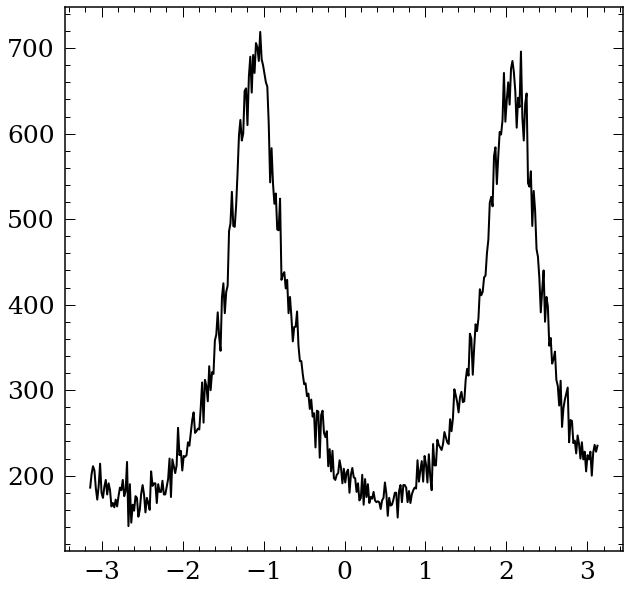

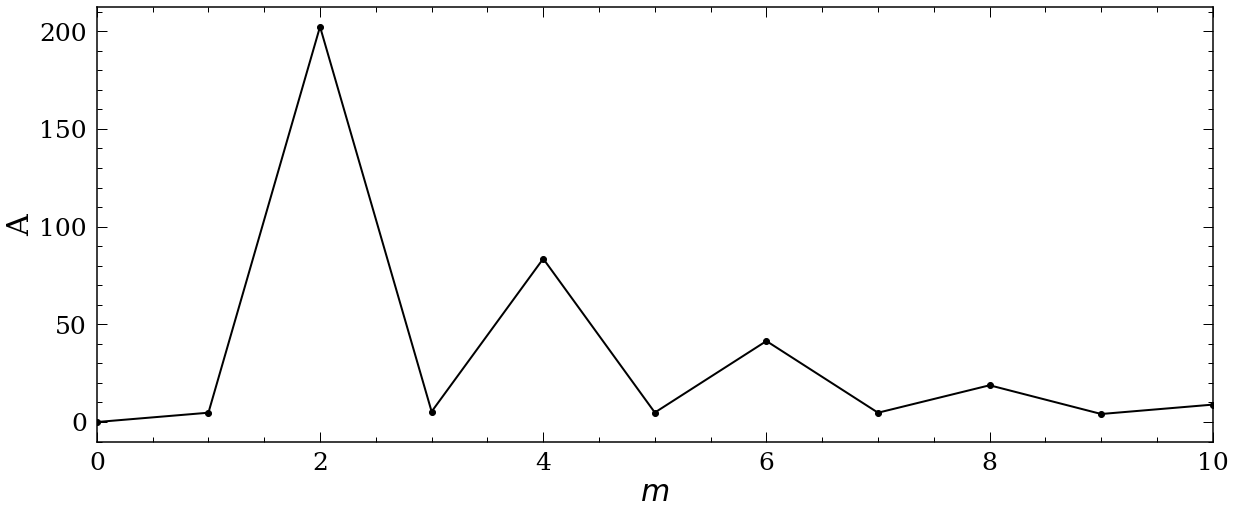

In [122]:
rbar=3
drbar=0.1
dub=3

data_r = data.loc[abs(data['R']-rbar)<drbar].reset_index(drop=True)
dens = np.histogram(data_r['phi'],bins=np.linspace(-np.pi,np.pi,360));

### FFT
degs = (dens[1][:-1]+dens[1][1:])/2
dens_p = dens[0]

"""
for i in range(dub):
    degs = np.append(degs, (degs+(i+1)*np.pi))
    dens_p = np.append(dens_p, dens_p)
"""
plt.plot(dens[1][:-1], dens[0], 'k-')
#plt.plot(dens[1][:-1], np.sin(2*dens[1][:-1]-2)*100)

N = len(dens_p)
Ts = (max(degs)-min(degs))/N
yf = np.fft.fft(dens_p-np.mean(dens_p))

Y = 2./N*abs(yf[0:N//2])

barangle=-np.angle(yf[2])/2.
print(barangle)
plt.figure(figsize=(20,8))

frq=np.linspace(0, max(degs)/(2.*T), int(N/2))
plt.plot(Y ,'k-o')
plt.xlim([0,10])
plt.xlabel('$m$')
plt.ylabel('A')

In [ ]:

for i in range(1,len(sims)):
    if sims[i]=='g1.12e12_3x9':
        continue
    else:
        print('Generate ')
        generatepkl(sims[i])
        cosmictime, patternspeed, amps = calc_bar_speed(sims[i], rbar=3.5, drbar=0.5)


g8.26e11_2x4x8


  1%|          | 1/180 [00:00<01:19,  2.27it/s]

no halo!


  4%|▍         | 8/180 [00:27<07:41,  2.68s/it]

no stars!


 20%|██        | 36/180 [01:15<06:45,  2.82s/it]

no IDs!


100%|██████████| 180/180 [02:13<00:00,  1.35it/s]


g8.26e11_2x4x8
{260: 'g8.26e11_2x4x8/8.26e11.00260', 650: 'g8.26e11_2x4x8/8.26e11.00650', 720: 'g8.26e11_2x4x8/8.26e11.00720', 310: 'g8.26e11_2x4x8/8.26e11.00310', 80: 'g8.26e11_2x4x8/8.26e11.00080', 990: 'g8.26e11_2x4x8/8.26e11.00990', 1170: 'g8.26e11_2x4x8/8.26e11.01170', 1540: 'g8.26e11_2x4x8/8.26e11.01540', 1860: 'g8.26e11_2x4x8/8.26e11.01860', 1910: 'g8.26e11_2x4x8/8.26e11.01910', 1430: 'g8.26e11_2x4x8/8.26e11.01430', 1000: 'g8.26e11_2x4x8/8.26e11.01000', 1390: 'g8.26e11_2x4x8/8.26e11.01390', 860: 'g8.26e11_2x4x8/8.26e11.00860', 170: 'g8.26e11_2x4x8/8.26e11.00170', 910: 'g8.26e11_2x4x8/8.26e11.00910', 1990: 'g8.26e11_2x4x8/8.26e11.01990', 1080: 'g8.26e11_2x4x8/8.26e11.01080', 1650: 'g8.26e11_2x4x8/8.26e11.01650', 1260: 'g8.26e11_2x4x8/8.26e11.01260', 1310: 'g8.26e11_2x4x8/8.26e11.01310', 1720: 'g8.26e11_2x4x8/8.26e11.01720', 1620: 'g8.26e11_2x4x8/8.26e11.01620', 1210: 'g8.26e11_2x4x8/8.26e11.01210', 1360: 'g8.26e11_2x4x8/8.26e11.01360', 1750: 'g8.26e11_2x4x8/8.26e11.01750', 1180: 

  7%|▋         | 12/179 [00:00<00:01, 115.27it/s]

can't read in snaps!
can't read in snaps!


 18%|█▊        | 32/179 [00:00<00:03, 38.09it/s] 

can't read in snaps!
can't read in snaps!


 69%|██████▉   | 124/179 [00:35<00:37,  1.47it/s]/tmp/ipykernel_3569363/669544192.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 71%|███████   | 127/179 [00:37<00:40,  1.27it/s]/tmp/ipykernel_3569363/669544192.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 73%|███████▎  | 131/179 [00:39<00:34,  1.39it/s]/tmp/ipykernel_3569363/669544192.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 75%|███████▍  | 134/179 [00:41<00:28,  1.57it/s]/tmp/ipykernel_3569363/669544192.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 77%|███████▋  | 137/179 [00:44<00:30,  1.39it/s]/tmp/ipykernel_3569363/669544192.py:135: RuntimeWarning: divide

g7.08e11_5x10


  1%|          | 1/160 [00:00<01:20,  1.97it/s]

no halo!


  6%|▌         | 9/160 [08:49<3:22:25, 80.43s/it]

In [17]:
plt.plot(cosmictime, patternspeed)

NameError: name 'cosmictime' is not defined

In [ ]:
calc_bar_speed(sims[i], rbar=3.5, drbar=0.5)

In [150]:
pd.DataFrame({k:out[k] for k in cols})

,iord,r,z,x,y
0,59330548,0.198781,0.181828,0.076785,0.023594
1,59330549,0.148252,0.133612,0.042697,0.047997
2,59330550,0.177428,0.171368,0.012882,0.044135
3,59330551,0.047608,0.016560,-0.018496,-0.040622
